# Учимся использовать RL для обучения стратегий игры в блэкджек

In [1]:
import blackjack
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Часть первая, с блекджеком и стратегиями

### 1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остал/ьных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [2]:
# Используем класс по ссылке задания - https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py 
env = blackjack.BlackjackEnv(natural=True)

In [3]:
# Усредняем награду по n эпизодам
n = 100000
rewards = []
for i in range(n):
    obs = env.reset()
    while(True):
        ifobs, reward, done, _ = env.step(0) (obs[0] >= 19) and (obs[0] <= 21):
            obs, reward, done, _ = env.step(0)
        else:
            obs, reward, done, _ = env.step(1)
        if done:
            break
    rewards.append(reward)
np.mean(rewards)

-0.1781

### 2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym

In [4]:
class Q_learning():
    # epsilon-greedy Q learning
    
    def __init__(self, env, alpha=0.1, gamma=1, eps=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        self.q = np.zeros(([d.n for d in env.observation_space] + [env.action_space.n]))
        
        
    def get_action(self, obs, train=True):
        # switch to greedy when we don't need exploration
        if train:
            # epsilon-greedy
            if np.random.rand() < self.eps:
                # random action
                action = np.random.randint(0, self.env.action_space.n)
            else:
                # use policy (action with the highest q(s, a))
                q_s  = self.q[obs[0], obs[1], int(obs[2])] # get action q's for given state, n = action_space
                action = np.argmax(q_s)
            return action
        else:
            # greedy
            q_s  = self.q[obs[0], obs[1], int(obs[2])] # get action q's for given state, n = action_space
            action = np.argmax(q_s)
            return action


    def train(self, steps, steps_to_validate, validation_episodes=100000):
        obs = self.env.reset()
        self.validation_rewards = []
        for i in tqdm(range(steps)):
            action = self.get_action(obs)
            # performing the action
            obs_next, reward, done, _ = self.env.step(action)
            self.q[obs[0], obs[1], int(obs[2]), action] = (1 - self.alpha) * self.q[obs[0], obs[1], int(obs[2]), action] +\
                self.alpha * (reward + self.gamma * np.max(self.q[obs_next[0], obs_next[1], int(obs_next[2])]))
            if done:
                obs = self.env.reset()
            else:
                obs = obs_next
            if ((i + 1) % steps_to_validate==0 and i!=0):
                mean_reward = self.validate(validation_episodes)
                self.validation_rewards.append(mean_reward)
        print('Training done')
        return self.validation_rewards
        
    def validate(self, episodes):
        rewards = []
        for i in range(episodes):
            obs = self.env.reset()
            while(True):
                action = self.get_action(obs, train=False)
                obs, reward, done, _ = self.env.step(action)
                if done:
                    break
            rewards.append(reward)
        return np.mean(rewards)

### 3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.


In [5]:
env = blackjack.BlackjackEnv(natural=True)
q_learing = Q_learning(env, alpha=0.9, eps=0.2, gamma=0.99)
results = q_learing.train(int(5e6), int(5e5), int(1e5))

100%|██████████| 5000000/5000000 [05:05<00:00, 16374.72it/s]

Training done


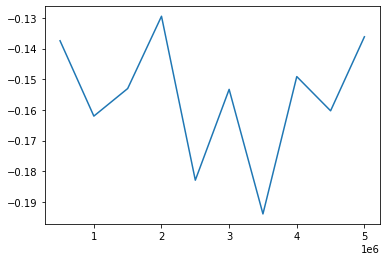

In [6]:
plt.plot([(i+1)*5e5 for i in range(len(results))], results)

In [7]:
print(f'С учетом относительно оптимальных гиперпараметров мы в среднем выигрываем {results[-1]} ставок')

С учетом относительно оптимальных гиперпараметров мы в среднем выигрываем -0.136125 ставок


# Часть вторая, удвоенная

### 4. Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.


In [8]:
# см. blackjack.py - добавлено третье действие в новый класс
env = blackjack.BlackjackDoubleEnv(natural=True)
env.action_space

Discrete(3)

### 5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [9]:
class Monte_Carlo_control():
    # epsilon-greedy Q learning
    
    def __init__(self, env, gamma=0.99):
        self.env = env
        self.gamma = gamma
        self.q = np.zeros(([d.n for d in env.observation_space] + [env.action_space.n]))
        self.ret_n = np.zeros(([d.n for d in env.observation_space] + [env.action_space.n]))
        
        
    def get_action(self, obs, train=True):
        # greedy
        q_s  = self.q[obs[0], obs[1], int(obs[2])] # get action q's for given state, n = action_space
        action = np.argmax(q_s)
        return action

    def generate_episode (self):
        # generating episode with random initial state and action
        episode = []
        obs = self.env.reset()
        # randomly initializing first action
        action = np.random.randint(0, self.env.action_space.n)
        while(True):
            obs_next, reward, done, _ = self.env.step(action)
            episode.append((obs, action, reward))
            obs = obs_next
            action = self.get_action(obs, train=False)
            if done:
                break
        return episode

    def train(self, steps, steps_to_validate, validation_episodes=100000):
        self.validation_rewards = []
        for i in tqdm(range(steps)):
            episode = self.generate_episode()
            g = 0
            for step in reversed(episode):
                obs, action, reward = step
                g = reward + self.gamma * g
                cur_ret = self.q[obs[0], obs[1], int(obs[2]), action]
                cur_ret_n = self.ret_n[obs[0], obs[1], int(obs[2]), action]
                # updating q using running mean of ret
                self.q[obs[0], obs[1], int(obs[2]), action] = cur_ret * cur_ret_n / (cur_ret_n + 1) + g / (cur_ret_n + 1)
                self.ret_n[obs[0], obs[1], int(obs[2]), action] += 1                
            if ((i + 1) % steps_to_validate==0 and i!=0):
                mean_reward = self.validate(validation_episodes)
                self.validation_rewards.append(mean_reward)
        print('Training done')
        return self.validation_rewards
        
    def validate(self, episodes):
        rewards = []
        for i in range(episodes):
            obs = self.env.reset()
            while(True):
                action = self.get_action(obs, train=False)
                obs, reward, done, _ = self.env.step(action)
                if done:
                    break
            rewards.append(reward)
        return np.mean(rewards)

In [10]:
env_double = blackjack.BlackjackDoubleEnv(natural=True)
mc_double = Monte_Carlo_control(env_double, gamma=0.99)
results_double = mc_double.train(int(1e6), int(1e5), int(1e5))

100%|██████████| 1000000/1000000 [01:40<00:00, 9909.64it/s]

Training done


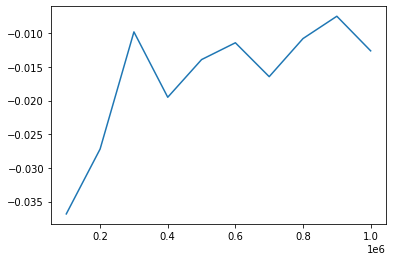

In [11]:
plt.plot([(i+1)*1e5 for i in range(len(results_double))], results_double)

In [12]:
print(f'В игре с двойной ставкой мы в среднем выигрываем {results_double[-1]} ставок')

В игре с двойной ставкой мы в среднем выигрываем -0.01261 ставок


##### Тестируем Monte Carlo control на обычном блэкджеке для сравнения с Q learning

In [14]:
env = blackjack.BlackjackEnv(natural=True)
mc = Monte_Carlo_control(env, gamma=0.99)
results_mc_normal = mc.train(int(1e6), int(1e5), int(1e5))

100%|██████████| 1000000/1000000 [01:41<00:00, 9894.69it/s]

Training done


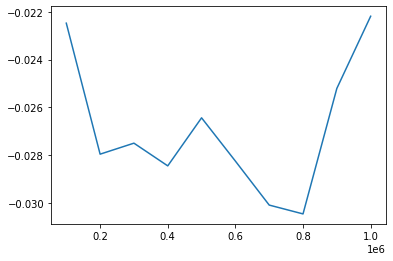

In [15]:
plt.plot([(i+1)*1e5 for i in range(len(results_mc_normal))], results_mc_normal)

In [16]:
print(f'С учетом относительно оптимальных гиперпараметров мы в среднем выигрываем {results_mc_normal[-1]} ставок, что немного лучше, чем в Q learning')

С учетом относительно оптимальных гиперпараметров мы в среднем выигрываем -0.022185 ставок, что немного лучше, чем в Q learning


# Часть третья, в главной роли — Дастин Хоффман

### 6. Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).

In [17]:
# см. blackjack.py - добавлена система подсчёта «Плюс-минус», дефолтно - 6 колод
env_6 = blackjack.BlackjackDouble_6_Env(natural=True)

In [18]:
# Умеет выводить как текущий счетчик, так и связянную с этим дельту вероятности выигрыша
env_6.get_true_count(), env_6.get_proba_diff()

(0.0, 0.0009)

### 7. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [19]:
# Q learning с изменением в политике
class Q_learning_6():
    # epsilon-greedy Q learning
    
    def __init__(self, env, alpha=0.1, gamma=1, eps=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        self.q = np.zeros(([d.n for d in env.observation_space] + [env.action_space.n]))
        
        
    def get_action(self, obs, proba_diff=0, train=True):
        # switch to greedy when we don't need exploration
        if train:
            # epsilon-greedy
            if np.random.rand() < self.eps:
                # random action
                action = np.random.randint(0, self.env.action_space.n)
            else:
                # use policy (action with the highest q(s, a))
                q_s  = self.q[obs[0], obs[1], int(obs[2])].copy() # get action q's for given state, n = action_space
                q_s += np.array([i * proba_diff for i in range(self.env.action_space.n)])
                action = np.argmax(q_s)
            return action
        else:
            # greedy
            q_s  = self.q[obs[0], obs[1], int(obs[2])].copy() # get action q's for given state, n = action_space
            q_s += np.array([i * proba_diff for i in range(self.env.action_space.n)])
            action = np.argmax(q_s)
            return action


    def train(self, steps, steps_to_validate, validation_episodes=100000):
        obs = self.env.reset()
        self.validation_rewards = []
        for i in tqdm(range(steps)):
            proba_diff = self.env.get_proba_diff()
            action = self.get_action(obs, proba_diff)
            # performing the action
            obs_next, reward, done, _ = self.env.step(action)
            self.q[obs[0], obs[1], int(obs[2]), action] = (1 - self.alpha) * self.q[obs[0], obs[1], int(obs[2]), action] +\
                self.alpha * (reward + self.gamma * np.max(self.q[obs_next[0], obs_next[1], int(obs_next[2])]))
            if done:
                obs = self.env.reset()
            else:
                obs = obs_next
            if ((i + 1) % steps_to_validate==0 and i!=0):
                mean_reward = self.validate(validation_episodes)
                self.validation_rewards.append(mean_reward)
        print('Training done')
        return self.validation_rewards
        
    def validate(self, episodes):
        rewards = []
        for i in range(episodes):
            obs = self.env.reset()
            while(True):
                proba_diff = self.env.get_proba_diff()
                action = self.get_action(obs, proba_diff, train=False)
                obs, reward, done, _ = self.env.step(action)
                if done:
                    break
            rewards.append(reward)
        return np.mean(rewards)

In [21]:
env_6 = blackjack.BlackjackDouble_6_Env(natural=True)
q_learning_6 = Q_learning_6(env_6, alpha=0.9, eps=0.2, gamma=0.99)
results_6 = q_learning_6.train(int(1e6), int(1e5), int(1e5))

100%|██████████| 1000000/1000000 [00:57<00:00, 17537.90it/s]

Training done


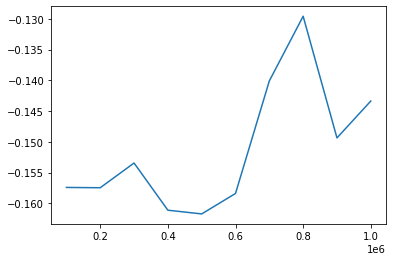

In [22]:
plt.plot([(i+1)*1e5 for i in range(len(results_6))], results_6)

In [23]:
print(f'В игре с подсчетом мы в среднем выигрываем {results_6[-1]} ставок')

В игре с подсчетом мы в среднем выигрываем -0.143375 ставок


##### Тестируем тот же Q learning на двойном блэкджеке без подсчета для sense check - результаты без подсчета должны быть ниже

In [24]:
env_double = blackjack.BlackjackDoubleEnv(natural=True)
q_learning_double = Q_learning(env_double, alpha=0.9, eps=0.2, gamma=0.99)
results_double_q = q_learning_double.train(int(1e6), int(1e5), int(1e5))

100%|██████████| 1000000/1000000 [01:38<00:00, 10196.62it/s]

Training done


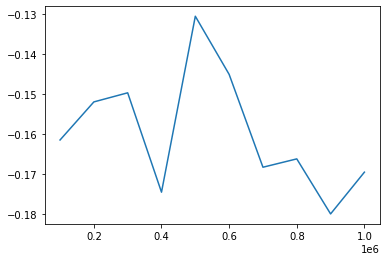

In [25]:
plt.plot([(i+1)*1e5 for i in range(len(results_double_q))], results_double_q)

In [26]:
print(f'В игре с подсчетом мы в среднем выигрываем {results_double_q[-1]} ставок - убедиились, что подсчет дает прирост выигрыша')

В игре с подсчетом мы в среднем выигрываем -0.169565 ставок - убедиились, что подсчет дает прирост выигрыша
